# normal_model

## time pyd_data

In [1]:
# ================== 1️⃣ 导入路径与函数 ==================
%run ../_init_path.py

import os
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph, add_self_loops

# === 导入模型结构 ===
from models import GraphContrastiveLearner, augment_graph, summarize_graph


# ===================== 0️⃣ 路径设置 =====================
train_graph_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/all_class_morenode_high_similar/train/pyg/train_graph_with_labelmask.pt"
val_graph_path   = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/all_class_morenode_high_similar/val/pyg/graph.pt"
test_graph_path  = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/all_class_morenode_high_similar/test/pyg/graph.pt"

save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/model_save/time_morenode_high_similar_high_similar"
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ===================== 1️⃣ 加载图数据 =====================
print("\n========== 加载 train 图（带 label mask） ==========")
train_data = torch.load(train_graph_path)
summarize_graph(train_data)

print("\n========== 加载 val 图 ==========")
val_data = torch.load(val_graph_path)

print("\n========== 加载 test 图 ==========")
test_data = torch.load(test_graph_path)


# ===================== 2️⃣ 对 train_data.x 做 Z-score 标准化 =====================
x_mean = train_data.x.mean(dim=0, keepdim=True)
x_std  = train_data.x.std(dim=0, keepdim=True) + 1e-6
train_data.x = (train_data.x - x_mean) / x_std

print("🎯 已完成 train_data.x 标准化")

x_mean = test_data.x.mean(dim=0, keepdim=True)
x_std  = test_data.x.std(dim=0, keepdim=True) + 1e-6
test_data.x = (test_data.x - x_mean) / x_std

print("🎯 已完成 test_data.x 标准化")

# ===================== 3️⃣ 构造 batch 子图 =====================
batch_size = 1024
num_nodes = train_data.num_nodes

perm = torch.randperm(num_nodes)

batches = []
for i in range(0, num_nodes, batch_size):
    node_idx = perm[i:i + batch_size]

    # ---- 提取子图（必须 CPU）----
    sub_edge_index, _ = subgraph(
        node_idx,
        train_data.edge_index,
        relabel_nodes=True
    )

    sub_x = train_data.x[node_idx]

    # ---------- ⭐ 加入自环 ----------
    sub_edge_index, _ = add_self_loops(
        sub_edge_index, num_nodes=sub_x.size(0)
    )

    sub_data = Data(
        x=sub_x,
        edge_index=sub_edge_index,
    )
    batches.append(sub_data)

print(f"📌 共生成 {len(batches)} 个子图 batch")

loader = DataLoader(batches, batch_size=1, shuffle=True)


# ===================== 4️⃣ 初始化模型 =====================
in_dim = train_data.x.size(1)
hidden_dim = 256
out_dim = 256
proj_dim = 128
tau = 0.5

model = GraphContrastiveLearner(in_dim, hidden_dim, out_dim, proj_dim, tau).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/src

========== 加载 train 图（带 label mask） ==========

🧩 Graph Data Summary
📊 节点数量 (num_nodes): 4500
📈 节点特征维度 (num_features): 4
🔗 边数量 (num_edges): 4500000
🔁 自环数量 (self-loops): 0
🎯 标签维度 (y_dim): torch.Size([4500])

🧾 Data对象包含字段: ['y', 'x', 'train_withlabel_mask', 'train_nolabel_mask', 'edge_index']


========== 加载 val 图 ==========

========== 加载 test 图 ==========
🎯 已完成 train_data.x 标准化
🎯 已完成 test_data.x 标准化


/tmp/ipykernel_47601/1282636376.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_graph_path)
/tmp/ipykernel_47601/1282636376.py:31: FutureW

📌 共生成 5 个子图 batch


## 训练

In [2]:
# ===================== 5️⃣ Batch 训练 =====================
epochs = 200

best_loss = float("inf")
best_model_path = os.path.join(save_dir, f"KAIST_normal_pretrain_best.pt")

print("\n================= 🚀 开始 Batch 对比学习训练 =================\n")

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0

    for batch_data in loader:
        batch_data = batch_data[0].to(device)   # batch_size=1 → 取第 0 个

        # ---- 生成两份增强视图 ----
        data1 = augment_graph(
            batch_data,
            feature_drop_prob=0.2,
            edge_drop_prob=0.1,
            noise_std=0.02
        ).to(device)

        data2 = augment_graph(
            batch_data,
            feature_drop_prob=0.2,
            edge_drop_prob=0.1,
            noise_std=0.02
        ).to(device)

        # ---- 计算 InfoNCE 对比损失 ----
        loss = model.compute_loss(
            data1.x, data1.edge_index,
            data2.x, data2.edge_index
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # ======== 日志输出 ========
    if epoch % 10 == 0:
        print(f"Epoch [{epoch:03d}/{epochs}] | InfoNCE Loss: {total_loss:.4f}")

    # ======== 保存当前最优模型 ========
    if total_loss < best_loss:
        best_loss = total_loss

        torch.save({
            "model_state_dict": model.state_dict(),
            "best_loss": best_loss,
            "epoch": epoch,
            "config": {
                "in_dim": in_dim,
                "hidden_dim": hidden_dim,
                "out_dim": out_dim,
                "proj_dim": proj_dim,
                "tau": tau
            }
        }, best_model_path)

        print(f"💾 [BEST MODEL UPDATED] Epoch {epoch} | Loss={total_loss:.4f}")


# ===================== 最终模型保存 =====================
final_path = os.path.join(save_dir, f"KAIST_normal_pretrain_epoch{epochs}.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "epoch": epochs,
    "config": {
        "in_dim": in_dim,
        "hidden_dim": hidden_dim,
        "out_dim": out_dim,
        "proj_dim": proj_dim,
        "tau": tau
    }
}, final_path)

print(f"\n🏁 最终模型已保存至: {final_path}")
print(f"🏆 最优模型已保存至: {best_model_path} | best_loss={best_loss:.4f}")



================= 🚀 开始 Batch 对比学习训练 =================

💾 [BEST MODEL UPDATED] Epoch 1 | Loss=33.0961
💾 [BEST MODEL UPDATED] Epoch 2 | Loss=31.7197
💾 [BEST MODEL UPDATED] Epoch 3 | Loss=31.3722
💾 [BEST MODEL UPDATED] Epoch 4 | Loss=31.2332
💾 [BEST MODEL UPDATED] Epoch 5 | Loss=31.1104
💾 [BEST MODEL UPDATED] Epoch 6 | Loss=31.0423
💾 [BEST MODEL UPDATED] Epoch 7 | Loss=30.8962
💾 [BEST MODEL UPDATED] Epoch 8 | Loss=30.7779
💾 [BEST MODEL UPDATED] Epoch 9 | Loss=30.7409
Epoch [010/200] | InfoNCE Loss: 30.7004
💾 [BEST MODEL UPDATED] Epoch 10 | Loss=30.7004
💾 [BEST MODEL UPDATED] Epoch 11 | Loss=30.5929
💾 [BEST MODEL UPDATED] Epoch 12 | Loss=30.3706
💾 [BEST MODEL UPDATED] Epoch 13 | Loss=30.2385
💾 [BEST MODEL UPDATED] Epoch 14 | Loss=30.1354
💾 [BEST MODEL UPDATED] Epoch 15 | Loss=29.9719
💾 [BEST MODEL UPDATED] Epoch 16 | Loss=29.7930
💾 [BEST MODEL UPDATED] Epoch 17 | Loss=29.6794
💾 [BEST MODEL UPDATED] Epoch 18 | Loss=29.6263
💾 [BEST MODEL UPDATED] Epoch 19 | Loss=29.4964
Epoch [020/200] | In

## 效果可视化

/tmp/ipykernel_47601/708445538.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ 使用训练时的原始模型读取成功！不会报错
⭐ Train Embeddings Shape: (4500, 128)
⭐ Test  Embeddings Shape: (1500, 128)


/home/charles/miniconda3/envs/d2l/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/charles/miniconda3/envs/d2l/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


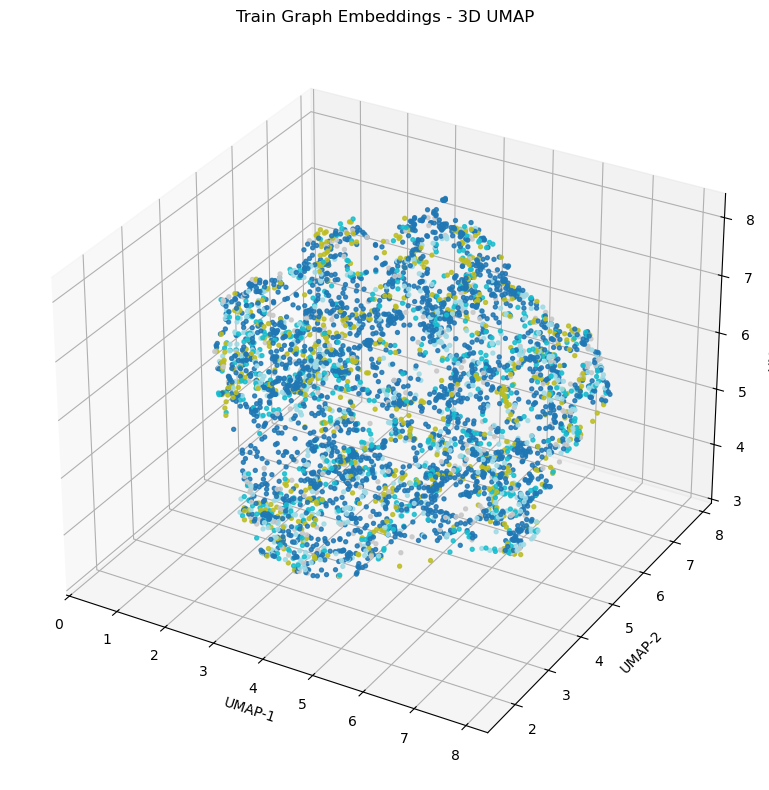

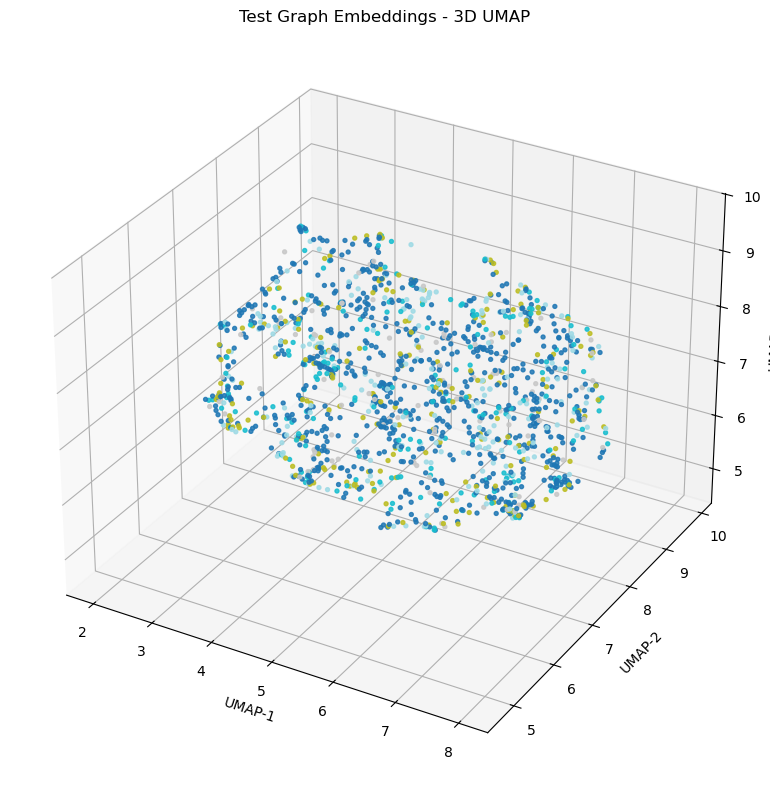


🎯 Train / Test 3D UMAP 全部完成并保存！


In [3]:
# ======================================================================
#                ⭐ 单 Cell：不会报错的模型加载 + Train/Test 3D 可视化 ⭐
# ======================================================================

# ====================== 环境导入 ======================
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from mpl_toolkits.mplot3d import Axes3D

# ====================== 路径 ======================
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/result/time_morenode_high_similar_high_similar"
os.makedirs(save_dir, exist_ok=True)

model_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/model_save/time_morenode_high_similar_high_similar/KAIST_normal_pretrain_best.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================== 加载训练时的真实模型结构 ======================
from models import GraphContrastiveLearner   

# ----- 加载 checkpoint -----
checkpoint = torch.load(model_path, map_location=device)
cfg = checkpoint["config"]

# ----- 按训练时的方式实例化模型（不会报错 👍）-----
model = GraphContrastiveLearner(
    in_dim     = cfg["in_dim"],
    hidden_dim = cfg["hidden_dim"],
    out_dim    = cfg["out_dim"],
    proj_dim   = cfg["proj_dim"],
    tau        = cfg["tau"] if "tau" in cfg else 0.5
).to(device)

# ----- 加载权重（不会报错 👍）-----
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ 使用训练时的原始模型读取成功！不会报错")

# ======================================================================
#                ⭐ 1️⃣ 提取 Train 和 Test 的嵌入
# ======================================================================

# 你前面已经：train_data / test_data = torch.load(...)
train_data = train_data.to(device)
test_data  = test_data.to(device)

with torch.no_grad():
    _, z_train = model(train_data.x, train_data.edge_index)
    _, z_test  = model(test_data.x,  test_data.edge_index)

train_emb = z_train.cpu().numpy()
test_emb  = z_test.cpu().numpy()

train_labels = train_data.y.cpu().numpy() if hasattr(train_data, "y") else np.zeros(train_emb.shape[0])
test_labels  = test_data.y.cpu().numpy() if hasattr(test_data,  "y") else np.zeros(test_emb.shape[0])

print(f"⭐ Train Embeddings Shape: {train_emb.shape}")
print(f"⭐ Test  Embeddings Shape: {test_emb.shape}")

# ======================================================================
#                ⭐ 2️⃣ 3D UMAP 降维
# ======================================================================
reducer_train = umap.UMAP(
    n_neighbors=10, min_dist=0.1, n_components=3,
    metric="cosine", random_state=42
)
train_umap = reducer_train.fit_transform(train_emb)

reducer_test = umap.UMAP(
    n_neighbors=10, min_dist=0.1, n_components=3,
    metric="cosine", random_state=42
)
test_umap = reducer_test.fit_transform(test_emb)

# ======================================================================
#                ⭐ 3️⃣ 绘制 Train 3D UMAP
# ======================================================================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    train_umap[:,0], train_umap[:,1], train_umap[:,2],
    c=train_labels, cmap='tab20', s=8, alpha=0.85
)

ax.set_title("Train Graph Embeddings - 3D UMAP")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2"); ax.set_zlabel("UMAP-3")

legend = plt.legend(
    *scatter.legend_elements(num=None),
    title="Labels", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8
)
ax.add_artist(legend)

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig(os.path.join(save_dir, "train_umap_3d.png"), dpi=300)
plt.show()

# ======================================================================
#                ⭐ 4️⃣ 绘制 Test 3D UMAP
# ======================================================================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    test_umap[:,0], test_umap[:,1], test_umap[:,2],
    c=test_labels, cmap='tab20', s=8, alpha=0.85
)

ax.set_title("Test Graph Embeddings - 3D UMAP")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2"); ax.set_zlabel("UMAP-3")

legend = plt.legend(
    *scatter.legend_elements(num=None),
    title="Labels", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8
)
ax.add_artist(legend)

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig(os.path.join(save_dir, "test_umap_3d.png"), dpi=300)
plt.show()

# ======================================================================
#                ⭐ 5️⃣ 保存嵌入
# ======================================================================
np.save(os.path.join(save_dir, "train_emb.npy"), train_emb)
np.save(os.path.join(save_dir, "train_umap_3d.npy"), train_umap)
np.save(os.path.join(save_dir, "test_emb.npy"),  test_emb)
np.save(os.path.join(save_dir, "test_umap_3d.npy"),  test_umap)

print("\n🎯 Train / Test 3D UMAP 全部完成并保存！")


## 下游训练 

In [4]:
# ======================================================================
#        ⭐ 单 Cell：使用 train_withlabel_mask 整图训练下游分类器 ⭐
# ======================================================================
%run ../_init_path.py
from models import GraphContrastiveLearner, DownstreamClassifier

import torch
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================================================================
# 1. 从 encoder 提取 h_train（你已经在外部加载好 model & train_data）
# ======================================================================

train_data = train_data.to(device)
model = model.to(device)
model.eval()

print("🚀 提取训练数据特征（Encoder forward）...")

with torch.no_grad():
    h_train, _ = model(train_data.x, train_data.edge_index)

h_train = h_train.detach()                   # [N, out_dim]
y_all = train_data.y                         # [N]
mask = train_data.train_withlabel_mask       # bool mask

idx = mask.nonzero(as_tuple=False).view(-1)  # 标记有标签的数据
h_labeled = h_train[idx]                     # [num_labeled, out_dim]
y_labeled = y_all[idx]                       # [num_labeled]

print(f"📌 有标签样本数: {h_labeled.shape[0]}")
print(f"📌 表征维度(out_dim): {h_labeled.shape[1]}")


# ======================================================================
# 2. 定义分类头（全图训练）
# ======================================================================

num_features = h_labeled.size(1)
num_classes = int(y_labeled.max().item() + 1)

classifier = DownstreamClassifier(
    in_dim=num_features,
    num_classes=num_classes,
    hidden_dim=128
).to(device)

optimizer = Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)


# ======================================================================
# 3. 整图训练（不分 batch）
# ======================================================================

epochs = 100
print("\n================== 🔥 开始下游分类训练（整图） ==================\n")

for epoch in range(1, epochs + 1):

    classifier.train()

    optimizer.zero_grad()

    logits = classifier(h_labeled)      # 全部 labeled 样本一起 forward
    loss = F.cross_entropy(logits, y_labeled)
    
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d}/{epochs} | Loss: {loss.item():.4f}")

print("\n🏁 下游线性分类训练完成（整图方式）！")


# ======================================================================
# 4. 保存分类器
# ======================================================================

save_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/model_save/time_morenode_high_similar/downstream/downstream_classifier.pt"

torch.save({
    "state_dict": classifier.state_dict(),
    "in_dim": num_features,
    "num_classes": num_classes
}, save_path)

print(f"💾 下游分类器已保存：{save_path}")


✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/src
🚀 提取训练数据特征（Encoder forward）...
📌 有标签样本数: 1350
📌 表征维度(out_dim): 256

================== 🔥 开始下游分类训练（整图） ==================

Epoch 005/100 | Loss: 2.4422
Epoch 010/100 | Loss: 2.1178
Epoch 015/100 | Loss: 1.7807
Epoch 020/100 | Loss: 1.5034
Epoch 025/100 | Loss: 1.3441
Epoch 030/100 | Loss: 1.2608
Epoch 035/100 | Loss: 1.1927
Epoch 040/100 | Loss: 1.1374
Epoch 045/100 | Loss: 1.0771
Epoch 050/100 | Loss: 1.0122
Epoch 055/100 | Loss: 0.9423
Epoch 060/100 | Loss: 0.8694
Epoch 065/100 | Loss: 0.7960
Epoch 070/100 | Loss: 0.7264
Epoch 075/100 | Loss: 0.6632
Epoch 080/100 | Loss: 0.6069
Epoch 085/100 | Loss: 0.5579
Epoch 090/100 | Loss: 0.5154
Epoch 095/100 | Loss: 0.4788
Epoch 100/100 | Loss: 0.4471

🏁 下游线性分类训练完成（整图方式）！
💾 下游分类器已保存

## 最终acc测试

In [5]:
# ======================================================================
#    ⭐ 单 Cell：加载上游模型 + 下游分类器，并计算 Train/Test Accuracy ⭐
# ======================================================================

import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================== 模型路径 ======================
pretrain_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/model_save/time_morenode_high_similar/KAIST_normal_pretrain_best.pt"

classifier_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model_opt/model_save/time_morenode_high_similar/downstream/downstream_classifier.pt"

print("📌 模型路径已设置")


# ====================== 加载模型结构 ======================
from models import GraphContrastiveLearner, DownstreamClassifier

# ------- 加载上游 GCL 模型 -------
ckpt = torch.load(pretrain_path, map_location=device)
cfg = ckpt["config"]

model = GraphContrastiveLearner(
    in_dim     = cfg["in_dim"],
    hidden_dim = cfg["hidden_dim"],
    out_dim    = cfg["out_dim"],
    proj_dim   = cfg["proj_dim"],
    tau        = cfg["tau"] if "tau" in cfg else 0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])   # ⭐ 不会报错的加载方式
model.eval()
print("✅ 上游模型加载成功！")


# ------- 加载下游分类器 -------
clf_ckpt = torch.load(classifier_path, map_location=device)
in_dim = clf_ckpt["in_dim"]
num_classes = clf_ckpt["num_classes"]

classifier = DownstreamClassifier(
    in_dim=in_dim,
    num_classes=num_classes,
    hidden_dim=128
).to(device)

classifier.load_state_dict(clf_ckpt["state_dict"])
classifier.eval()
print("✅ 下游分类器加载成功！")


# ====================== 加载 Train / Test 图 ======================
# 你在 notebook 中应该已经手动加载好了：
# train_data = torch.load(...)
# test_data = torch.load(...)

train_data = train_data.to(device)
test_data = test_data.to(device)

print("📌 Train/Test 图数据已加载至 GPU/CPU")


# ======================================================================
#          ⭐ 1️⃣ 提取 Train/Test 的 GCL encoder 表征 h
# ======================================================================
with torch.no_grad():
    h_train, _ = model(train_data.x, train_data.edge_index)
    h_test,  _ = model(test_data.x,  test_data.edge_index)

print("🔧 已提取上游编码特征 h_train / h_test")


# ======================================================================
#          ⭐ 2️⃣ Train Accuracy（仅 train_withlabel_mask）
# ======================================================================
train_mask = train_data.train_withlabel_mask
train_idx = train_mask.nonzero(as_tuple=False).view(-1)

h_labeled = h_train[train_idx]
y_labeled = train_data.y[train_idx]

with torch.no_grad():
    logits_train = classifier(h_labeled)
    pred_train = logits_train.argmax(dim=1)

acc_train = (pred_train == y_labeled).float().mean().item()

print(f"\n🎯 Train Accuracy (train_withlabel_mask) = {acc_train*100:.2f}%")


# ======================================================================
#          ⭐ 3️⃣ Test Accuracy（全部 test 节点）
# ======================================================================
with torch.no_grad():
    logits_test = classifier(h_test)
    pred_test = logits_test.argmax(dim=1)

acc_test = (pred_test == test_data.y).float().mean().item()

print(f"🎯 Test Accuracy  (all test nodes) = {acc_test*100:.2f}%")

print("\n🏁 全部 accuracy 评估完成！")


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# ====================== ⭐ Train metrics ======================
y_true_train = y_labeled.cpu().numpy()
y_pred_train = pred_train.cpu().numpy()

train_acc  = accuracy_score(y_true_train, y_pred_train)
train_prec = precision_score(y_true_train, y_pred_train, average="macro", zero_division=0)
train_reca = recall_score(y_true_train, y_pred_train, average="macro", zero_division=0)
train_f1   = f1_score(y_true_train, y_pred_train, average="macro", zero_division=0)

print("\n====================== TRAIN METRICS ======================")
print(f"Accuracy : {train_acc*100:.2f}%")
print(f"Precision: {train_prec*100:.2f}%")
print(f"Recall   : {train_reca*100:.2f}%")
print(f"F1-score : {train_f1*100:.2f}%")
print("===========================================================\n")


# ====================== ⭐ Test metrics ======================
y_true_test = test_data.y.cpu().numpy()
y_pred_test = pred_test.cpu().numpy()

test_acc  = accuracy_score(y_true_test, y_pred_test)
test_prec = precision_score(y_true_test, y_pred_test, average="macro", zero_division=0)
test_reca = recall_score(y_true_test, y_pred_test, average="macro", zero_division=0)
test_f1   = f1_score(y_true_test, y_pred_test, average="macro", zero_division=0)

print("======================= TEST METRICS =======================")
print(f"Accuracy : {test_acc*100:.2f}%")
print(f"Precision: {test_prec*100:.2f}%")
print(f"Recall   : {test_reca*100:.2f}%")
print(f"F1-score : {test_f1*100:.2f}%")
print("===========================================================\n")
# ======================================================================
#          ⭐ 4️⃣ 统计预测错误的样本（真实标签 vs 预测标签）
# ======================================================================

import numpy as np
from collections import Counter

# ========== Train 错误样本 ==========
wrong_train_idx = np.where(y_pred_train != y_true_train)[0]

print("============== TRAIN WRONG PREDICTIONS ==============")
print(f"❌ 错误样本数量：{len(wrong_train_idx)} / {len(y_true_train)}")

# 打印前 20 个错误样本（避免太长）
max_show = 20
for i in wrong_train_idx[:max_show]:
    print(f"Index {i:4d} | True = {y_true_train[i]} | Pred = {y_pred_train[i]}")
if len(wrong_train_idx) > max_show:
    print(f"... (共 {len(wrong_train_idx)} 个错样本，只显示前 {max_show} 个)")

# 每类错误统计
train_wrong_pairs = [(int(y_true_train[i]), int(y_pred_train[i])) for i in wrong_train_idx]
train_wrong_count = Counter(train_wrong_pairs)

print("\n🔍 Train 每类错误统计：(真标签 -> 预测标签)")
for (t, p), cnt in train_wrong_count.items():
    print(f"  {t} → {p} : {cnt} 次")


# ========== Test 错误样本 ==========
wrong_test_idx = np.where(y_pred_test != y_true_test)[0]

print("\n============== TEST WRONG PREDICTIONS ===============")
print(f"❌ 错误样本数量：{len(wrong_test_idx)} / {len(y_true_test)}")

for i in wrong_test_idx[:max_show]:
    print(f"Index {i:4d} | True = {y_true_test[i]} | Pred = {y_pred_test[i]}")
if len(wrong_test_idx) > max_show:
    print(f"... (共 {len(wrong_test_idx)} 个错样本，只显示前 {max_show} 个)")

# 每类错误统计
test_wrong_pairs = [(int(y_true_test[i]), int(y_pred_test[i])) for i in wrong_test_idx]
test_wrong_count = Counter(test_wrong_pairs)

print("\n🔍 Test 每类错误统计：(真标签 -> 预测标签)")
for (t, p), cnt in test_wrong_count.items():
    print(f"  {t} → {p} : {cnt} 次")

print("\n🏁 错误样本统计完成！")


📌 模型路径已设置
✅ 上游模型加载成功！
✅ 下游分类器加载成功！
📌 Train/Test 图数据已加载至 GPU/CPU
🔧 已提取上游编码特征 h_train / h_test


/tmp/ipykernel_47601/1075687278.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrain_path, map_location=device)
/tmp/ipykernel_47601/1075687278.py


🎯 Train Accuracy (train_withlabel_mask) = 40.52%
🎯 Test Accuracy  (all test nodes) = 40.93%

🏁 全部 accuracy 评估完成！

====================== TRAIN METRICS ======================
Accuracy : 40.52%
Precision: 15.34%
Recall   : 18.54%
F1-score : 15.65%

======================= TEST METRICS =======================
Accuracy : 40.93%
Precision: 19.86%
Recall   : 19.45%
F1-score : 17.05%

============== TRAIN WRONG PREDICTIONS ==============
❌ 错误样本数量：803 / 1350
Index    0 | True = 1 | Pred = 12
Index    2 | True = 1 | Pred = 11
Index    3 | True = 1 | Pred = 12
Index    5 | True = 1 | Pred = 12
Index    9 | True = 1 | Pred = 12
Index   11 | True = 1 | Pred = 12
Index   13 | True = 1 | Pred = 12
Index   15 | True = 1 | Pred = 12
Index   17 | True = 1 | Pred = 11
Index   25 | True = 1 | Pred = 12
Index   26 | True = 1 | Pred = 12
Index   31 | True = 1 | Pred = 12
Index   35 | True = 1 | Pred = 14
Index   37 | True = 1 | Pred = 12
Index   38 | True = 1 | Pred = 12
Index   41 | True = 1 | Pred = 12
